In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MultipleLocator, MaxNLocator
import seaborn as sns
from ast import literal_eval
from pathlib import Path
from itertools import product

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (18, 5)

/tmp/ipykernel_81951/411135857.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# load all files
df = pd.concat((pd.read_csv(f) for f in Path("../results").glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
df = df.drop("params",axis=1)

# eval columns
struct_cols = ['score_set',"stage_clf_params"]
df[struct_cols] = df[struct_cols].map(literal_eval)

# clean some stuff
df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")

<Axes: xlabel='stage', ylabel='train_ent'>

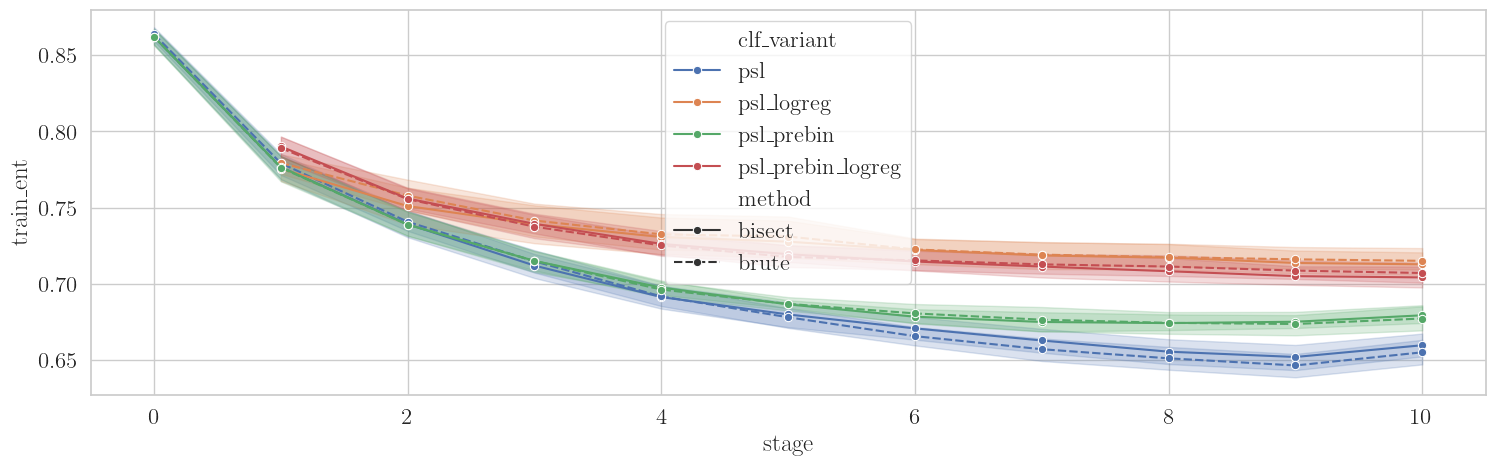

In [3]:
# 41945, 43979, 42900
df_ = df[
(df.dataset == 41945)
& (df.score_set==(-3, -2, -1, 1, 2, 3)) 
& (df.lookahead.isin({None,1})) 
& (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
]

fig,axes = plt.subplots()
sns.lineplot(data=df_, x="stage", y="train_ent", hue="clf_variant", style="method", marker="o", ax=axes)

In [4]:
%%capture

variants = [("clf_variant", "score_set"), ("clf_variant", "method"), ("clf_variant", "lookahead"), ("clf_variant", "stage_clf_params")]
fixed = dict(score_set = (-3,-2,-1,1,2,3),
             lookahead = 1,
             stage_clf_params = ('calibration_method', 'isotonic'),
             method = "bisect")

for hue, variant in variants:
    for dataset in ["thorax", 41945, 43979, 42900]:
        df_ = df[df.dataset == dataset]
        for k,v in fixed.items():
            if variant != k:
                df_ = df_[df_[k].isin({None, v})]
        
        for sample, metric in product(["train", "test"], ["ent", "acc", "wacc", "bacc", "roc", "brier"]):
            
            fig, axes = plt.subplots()
            sns.lineplot(data=df_, x="stage", y=f"{sample}_{metric}", hue=hue, style=variant, marker="o", ax=axes)
            fig.savefig(f"../fig/{dataset} {variant} {sample}_{metric}.png", bbox_inches="tight")